In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf #макроданные
from sklearn.linear_model import Ridge #линейная модель
from sklearn.ensemble import RandomForestRegressor #рандомный лес

import statsmodels.tsa.stattools as sm_stattools #статистические тесты для проверки
from statsmodels.tsa.arima.model import ARIMA #ARIMA
from pmdarima import auto_arima #автоподбор параметров для ARIMA

from sklearn.metrics import r2_score as R2, mean_squared_error as mse #метрики
from sklearn.model_selection import TimeSeriesSplit #кросс валидация временных рядов

import warnings #заглушить предупреждения
warnings.filterwarnings("ignore")

#### Задача
1) Выбрать и обучить бейзлайновую модель  
2) при необходимости учесть особенности предобработки данных для модели  
3) построить кроссвалидацию для временных рядов и использовать ее для оценки модели (если вы решили использовать какую-то другую схему кроссвалидации - отразите это в своем ноутбуке, желательно со ссылкой на источник - мне тоже будет интересно почитать статьи про альтернативы)  
4) проинтерпретировать решения модели, насколько это возможно  
5) финально оценить качество на тестовой выборке  
6) попробовать улучшить результат, работая с данными (генерация признаков, отсев признаков, другой способ предобработки и тп) или подбирая гиперпараметры модели, если они есть  

# Выгрузка данных

In [2]:
# предобработанная информация из файлов (задание EDA)
data=pd.read_csv('collected_data.csv',index_col=0).set_index('date',drop=True).drop('index',axis=1)

In [3]:
data.index=pd.to_datetime(data.index, errors='coerce')

In [4]:
company_names=data.company_name.unique()

# Блок с макроданными
Идеи: цена на нефть, газ, индекс акций (Dow John's, etc), ВВП США, экспорт нефти США, добыча нефти

In [5]:
DJI = yf.Ticker("^DJI")
DJI_hist = DJI.history(period="max").drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

brent_oil=yf.Ticker("BZ=F")
hist_oil = brent_oil.history(period="max").drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

In [6]:
data=data.merge(DJI_hist,left_index=True,right_index=True).merge(hist_oil,left_index=True,right_index=True)\
        .rename(columns={'Close_x':'Dow_John_s','Close_y':'Brent_price'})

In [7]:
ampy=data[data['company_name']=='AMPY.xlsx'].drop(columns=['company_name','company_number'])

In [8]:
#удаляю поля с незаполненными op_in или revenue
ampy=ampy.drop( ampy[(ampy.op_in == 0.) | (ampy.revenue == 0.)].index )

In [9]:
#слабая корреляция, необходимо добавить ещё макроданных
ampy.corr()

,op_in,revenue,Dow_John_s,Brent_price
op_in,1.000000,0.840469,-0.533116,0.531470
revenue,0.840469,1.000000,-0.526845,0.689274
Dow_John_s,-0.533116,-0.526845,1.000000,-0.318384
Brent_price,0.531470,0.689274,-0.318384,1.000000


# Блок с моделями

## L2 linear models

В этой части модель будет строиться для первой компании AMPY. Для остальных компаний построение отчётности будет аналогичным

### Revenue (L2)

In [10]:
X=ampy.drop(columns=['op_in','revenue'])
y=ampy.revenue

In [11]:
X_train, X_test = X[:-4], X[-4:]
y_train, y_test = y[:-4], y[-4:]

# нормализация данных
X_train = (X_train-X_train.mean() )/X_train.std()
X_test  = (X_test-X_test.mean() )/X_test.std()

In [12]:
ridge=Ridge().fit(X_train,y_train)
y_pred=ridge.predict(X_test)

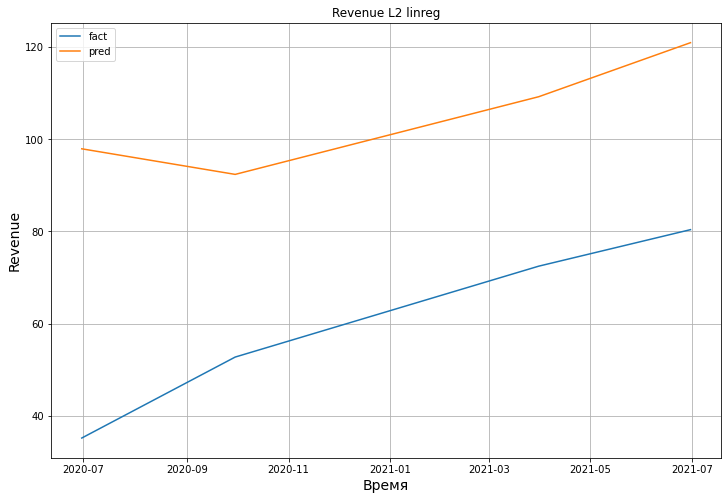

In [13]:
fig, ax=plt.subplots(figsize=(12,8))
plt.plot(y_test, label='fact')
plt.plot(pd.DataFrame({'pred':y_pred},index=y_test.index), label='pred' )
plt.legend()
ax.set(title='Revenue L2 linreg')
ax.set_xlabel('Время',size=14)
ax.set_ylabel('Revenue',size=14)
plt.grid()
plt.show()

In [14]:
print(f'mse:\t{mse(y_test,y_pred)}', f'R2:\t{R2(y_test,y_pred)}',sep='\n')

mse:	2127.4618416829626
R2:	-5.861046309327091


#### Cross validation (L2 - revenue)

In [15]:
tscv = TimeSeriesSplit(n_splits=5)
rmse = []
R2_adj=[]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train = (X_train-X_train.mean() )/X_train.std()
    X_test  = (X_test-X_test.mean() )/X_test.std()
    
    ridge=Ridge().fit(X_train,y_train)
    y_pred=ridge.predict(X_test)
    R2_adj.append(R2(y_test,y_pred) )
    rmse.append(mse(y_test,y_pred))

In [16]:
print(f'mean mse:\t{np.mean(rmse)}', f'mean R2:\t{np.mean(R2_adj)}',sep='\n')

mean mse:	3020.949712806561
mean R2:	-81.54506981198496


### Op_in (L2)

In [17]:
X=ampy.drop(columns=['op_in','revenue'])
y=ampy.op_in
X_train, X_test = X[:-4], X[-4:]
y_train, y_test = y[:-4], y[-4:]
# нормализация данных
X_train = (X_train-X_train.mean() )/X_train.std()
X_test  = (X_test-X_test.mean() )/X_test.std()

ridge=Ridge().fit(X_train,y_train)
y_pred=ridge.predict(X_test)

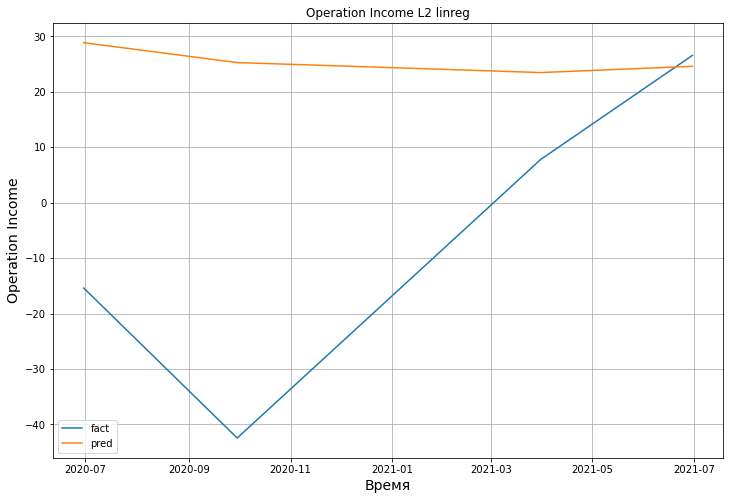

In [18]:
fig, ax=plt.subplots(figsize=(12,8))
plt.plot(y_test, label='fact')
plt.plot(pd.DataFrame({'pred':y_pred},index=y_test.index), label='pred' )
plt.legend()
ax.set(title='Operation Income L2 linreg')
ax.set_xlabel('Время',size=14)
ax.set_ylabel('Operation Income',size=14)
plt.grid()
plt.show()

In [19]:
print(f'mse:\t{mse(y_test,y_pred)}', f'R2:\t{R2(y_test,y_pred)}',sep='\n')

mse:	1697.599180846688
R2:	-1.5461053300050778


#### Cross validation (L2 - op_in)

In [20]:
rmse = []
R2_adj=[]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # нормализация данных
    X_train = (X_train-X_train.mean() )/X_train.std()
    X_test  = (X_test-X_test.mean() )/X_test.std()

    ridge=Ridge().fit(X_train,y_train)
    y_pred=ridge.predict(X_test)
    R2_adj.append(R2(y_test,y_pred) )
    rmse.append(mse(y_test,y_pred))

In [21]:
print(f'mean mse:\t{np.mean(rmse)}', f'mean R2:\t{np.mean(R2_adj)}',sep='\n')

mean mse:	809.7321197277142
mean R2:	-8.755161608798016


### Random Forest Regressor

### Revenue (RF)

In [22]:
X=ampy.drop(columns=['op_in','revenue'])
y=ampy.revenue
X_train, X_test = X[:-4], X[-4:]
y_train, y_test = y[:-4], y[-4:]

In [23]:
rf=RandomForestRegressor(random_state=0).fit(X_train,y_train)

In [24]:
y_pred=rf.predict(X_test)

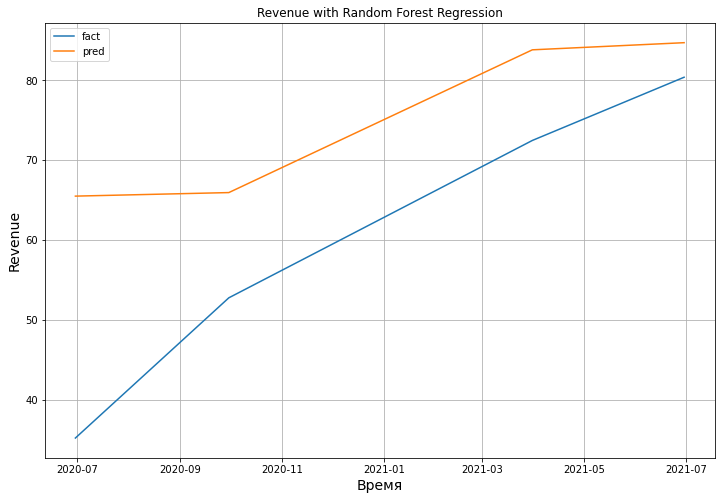

In [25]:
fig, ax=plt.subplots(figsize=(12,8))
plt.plot(y_test, label='fact')
plt.plot(pd.DataFrame({'pred':y_pred},index=y_test.index), label='pred' )
plt.legend()
ax.set(title='Revenue with Random Forest Regression')
ax.set_xlabel('Время',size=14)
ax.set_ylabel('Revenue',size=14)
plt.grid()
plt.show()

In [26]:
print(f'mse:\t{mse(y_test,y_pred)}', f'R2:\t{R2(y_test,y_pred)}',sep='\n')

mse:	310.2772821319261
R2:	-0.0006415907113284103


#### Cross validation (RF - revenue)

In [27]:
rmse = []
R2_adj=[]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf=RandomForestRegressor(random_state=0).fit(X_train,y_train)
    y_pred=rf.predict(X_test)
    R2_adj.append(R2(y_test,y_pred) )
    rmse.append(mse(y_test,y_pred))

In [28]:
print(f'mean mse:\t{np.mean(rmse)}', f'mean R2:\t{np.mean(R2_adj)}',sep='\n')

mean mse:	1756.9643979055513
mean R2:	-46.245003007329


### Operation income (RF)

In [29]:
X=ampy.drop(columns=['op_in','revenue'])
y=ampy.op_in
X_train, X_test = X[:-4], X[-4:]
y_train, y_test = y[:-4], y[-4:]
rf=RandomForestRegressor(random_state=0).fit(X_train,y_train)
y_pred=rf.predict(X_test)

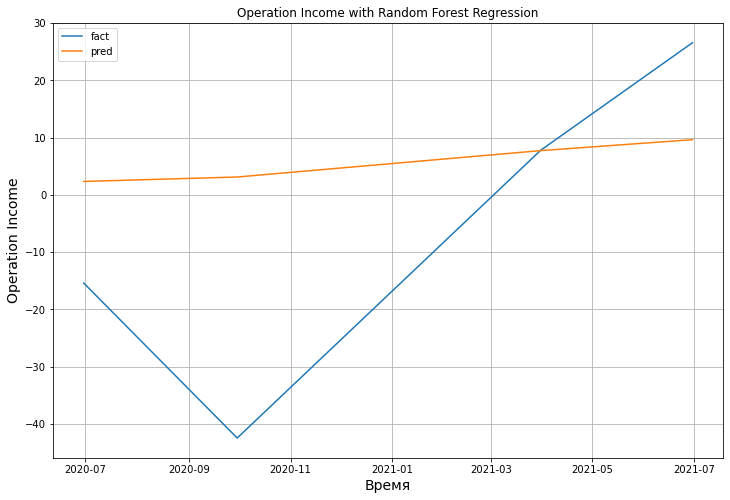

In [30]:
fig, ax=plt.subplots(figsize=(12,8))
plt.plot(y_test, label='fact')
plt.plot(pd.DataFrame({'pred':y_pred},index=y_test.index), label='pred' )
plt.legend()
ax.set(title='Operation Income with Random Forest Regression')
ax.set_xlabel('Время',size=14)
ax.set_ylabel('Operation Income',size=14)
plt.grid()
plt.show()

In [31]:
print(f'mse:\t{mse(y_test,y_pred)}', f'R2:\t{R2(y_test,y_pred)}',sep='\n')

mse:	669.28055030305
R2:	-0.003805135877491095


#### Cross validation (RF - op_in)

In [32]:
rmse = []
R2_adj=[]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf=RandomForestRegressor(random_state=0).fit(X_train,y_train)
    y_pred=rf.predict(X_test)
    R2_adj.append(R2(y_test,y_pred) )
    rmse.append(mse(y_test,y_pred))
print(f'mean mse:\t{np.mean(rmse)}', f'mean R2:\t{np.mean(R2_adj)}',sep='\n')

mean mse:	519.3163015490154
mean R2:	-6.464955292488608


## ARIMA без макроданных

In [33]:
data=pd.read_csv('collected_data.csv',index_col=0).set_index('date',drop=True).drop('index',axis=1)

In [34]:
data['op_in_l1']=(data.op_in-data.op_in.shift(1) ).fillna(0)
data['revenue_l1']=(data.revenue-data.revenue.shift(1)).fillna(0)
data['op_in_l2']=(data.op_in_l1-data.op_in_l1.shift(1)).fillna(0)
data['revenue_l2']=(data.revenue_l1-data.revenue_l1.shift(1)).fillna(0)
data['op_in_l3']=(data.op_in_l2-data.op_in_l2.shift(1)).fillna(0)
data['revenue_l3']=(data.revenue_l2-data.revenue_l2.shift(1)).fillna(0)

In [35]:
train={}
for name in company_names:
    df=data.query('company_name==@name')[:-4]
    train[f'{name}'] = df.drop( df[(df.op_in == 0.) | (df.revenue == 0.)].index )
test={}
for name in company_names:
    df=data.query('company_name==@name')[-4:]
    test[f'{name}']=df.drop( df[(df.op_in == 0.) | (df.revenue == 0.)].index )

$l_{1}$ - оператор разностей

### Revenue (ARIMA)

In [36]:
y_train=train['AMPY.xlsx'].revenue
y_test=test['AMPY.xlsx'].revenue
y_test.index=pd.to_datetime(y_test.index, errors='coerce')
y_train.index=pd.to_datetime(y_train.index, errors='coerce')

In [37]:
arima_model=auto_arima(y_train,random_state=0)
y_pred=arima_model.predict(n_periods=4)

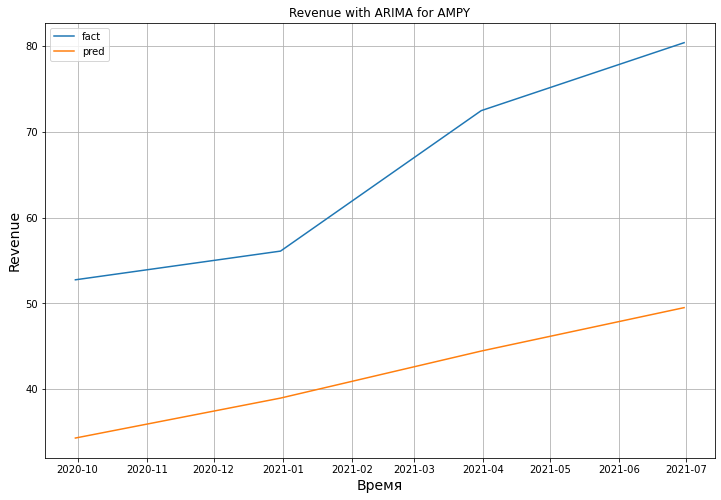

In [38]:
fig, ax=plt.subplots(figsize=(12,8))
plt.plot(y_test, label='fact')
plt.plot(y_pred, label='pred' )
plt.legend()
ax.set(title='Revenue with ARIMA for AMPY')
ax.set_xlabel('Время',size=14)
ax.set_ylabel('Revenue',size=14)
plt.grid()
plt.show()

#### Cross validation (ARIMA - revenue)

In [39]:
y=pd.concat([y_train,y_test])
tscv=TimeSeriesSplit(test_size=4,n_splits=5)
rmse = []
R2_adj=[]
for train_index, test_index in tscv.split(y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    arima_model=auto_arima(y_train,random_state=0)
    y_pred=arima_model.predict(n_periods=4)
    R2_adj.append(R2(y_test,y_pred) )
    rmse.append(mse(y_test,y_pred))
print(f'mean mse:\t{np.mean(rmse)}', f'mean R2:\t{np.mean(R2_adj)}',sep='\n')

mean mse:	281.4345157614106
mean R2:	-7.048896630776936


### Op_in (ARIMA)

In [40]:
y_train=train['AMPY.xlsx'].op_in
y_test=test['AMPY.xlsx'].op_in
y_test.index=pd.to_datetime(y_test.index, errors='coerce')
y_train.index=pd.to_datetime(y_train.index, errors='coerce')

arima_model=auto_arima(y_train,random_state=0)
y_pred=arima_model.predict(n_periods=4)

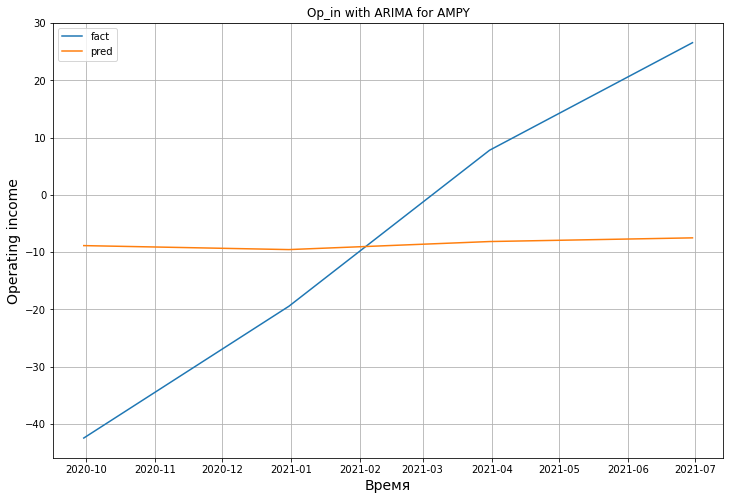

In [41]:
fig, ax=plt.subplots(figsize=(12,8))
plt.plot(y_test, label='fact')
plt.plot(y_pred, label='pred' )
plt.legend()
ax.set(title='Op_in with ARIMA for AMPY')
ax.set_xlabel('Время',size=14)
ax.set_ylabel('Operating income',size=14)
plt.grid()
plt.show()

#### Cross validation (ARIMA - op_in)

In [42]:
y=pd.concat([y_train,y_test])
tscv=TimeSeriesSplit(test_size=4,n_splits=5)
rmse = []
R2_adj=[]
for train_index, test_index in tscv.split(y):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    arima_model=auto_arima(y_train,random_state=0)
    y_pred=arima_model.predict(n_periods=4)
    R2_adj.append(R2(y_test,y_pred) )
    rmse.append(mse(y_test,y_pred))
print(f'mean mse:\t{np.mean(rmse)}', f'mean R2:\t{np.mean(R2_adj)}',sep='\n')

mean mse:	200.6852021659869
mean R2:	-3.1946845298848836


Вывод: без макроданных результат неудовлетворительный

Работа с сезонностью:

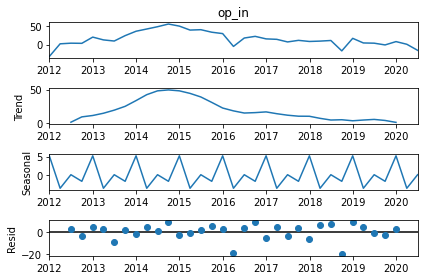

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y_train)
result.plot();